In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Dataset Loading and Exploration

emotion
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\mustafa\AppData\Local\Temp\ipykernel_29216\3262361977.py:1: SyntaxWarning: invalid escape sequence '\C'
  data_path = "archive\Crema"


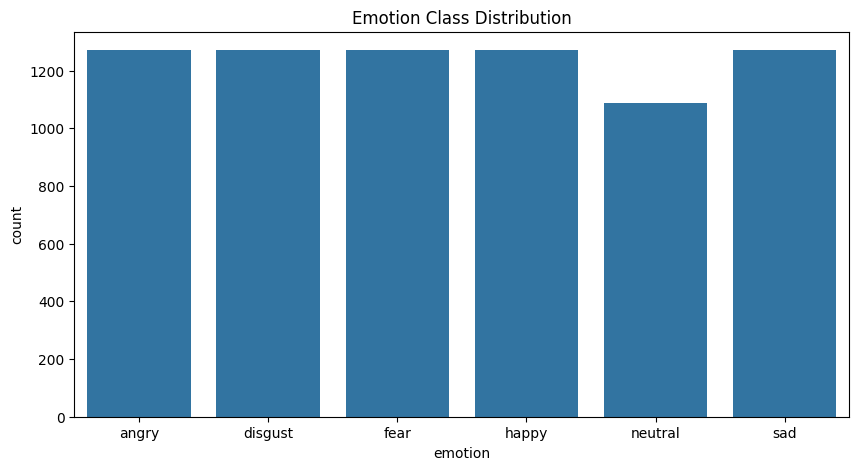

In [20]:
data_path = "archive\Crema"
audio_files = []
emotions = []
file_paths = []

# Walk through the directory structure
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
            # Extract emotion from filename (CREMA-D naming convention)
            parts = file.split('_')
            if len(parts) >= 3:
                emotion_code = parts[2]
                if emotion_code == 'SAD':
                    emotions.append('sad')
                elif emotion_code == 'ANG':
                    emotions.append('angry')
                elif emotion_code == 'DIS':
                    emotions.append('disgust')
                elif emotion_code == 'FEA':
                    emotions.append('fear')
                elif emotion_code == 'HAP':
                    emotions.append('happy')
                elif emotion_code == 'NEU':
                    emotions.append('neutral')
                else:
                    emotions.append('unknown')
            audio_files.append(file)

# Create a DataFrame
df = pd.DataFrame({'file_path': file_paths, 'emotion': emotions})
df = df[df['emotion'] != 'unknown']  # Remove unknown emotions

# Check class distribution
print(df['emotion'].value_counts())

# Visualize class distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='emotion')
plt.title('Emotion Class Distribution')
plt.show()

## The waveform of the audio for each emotion

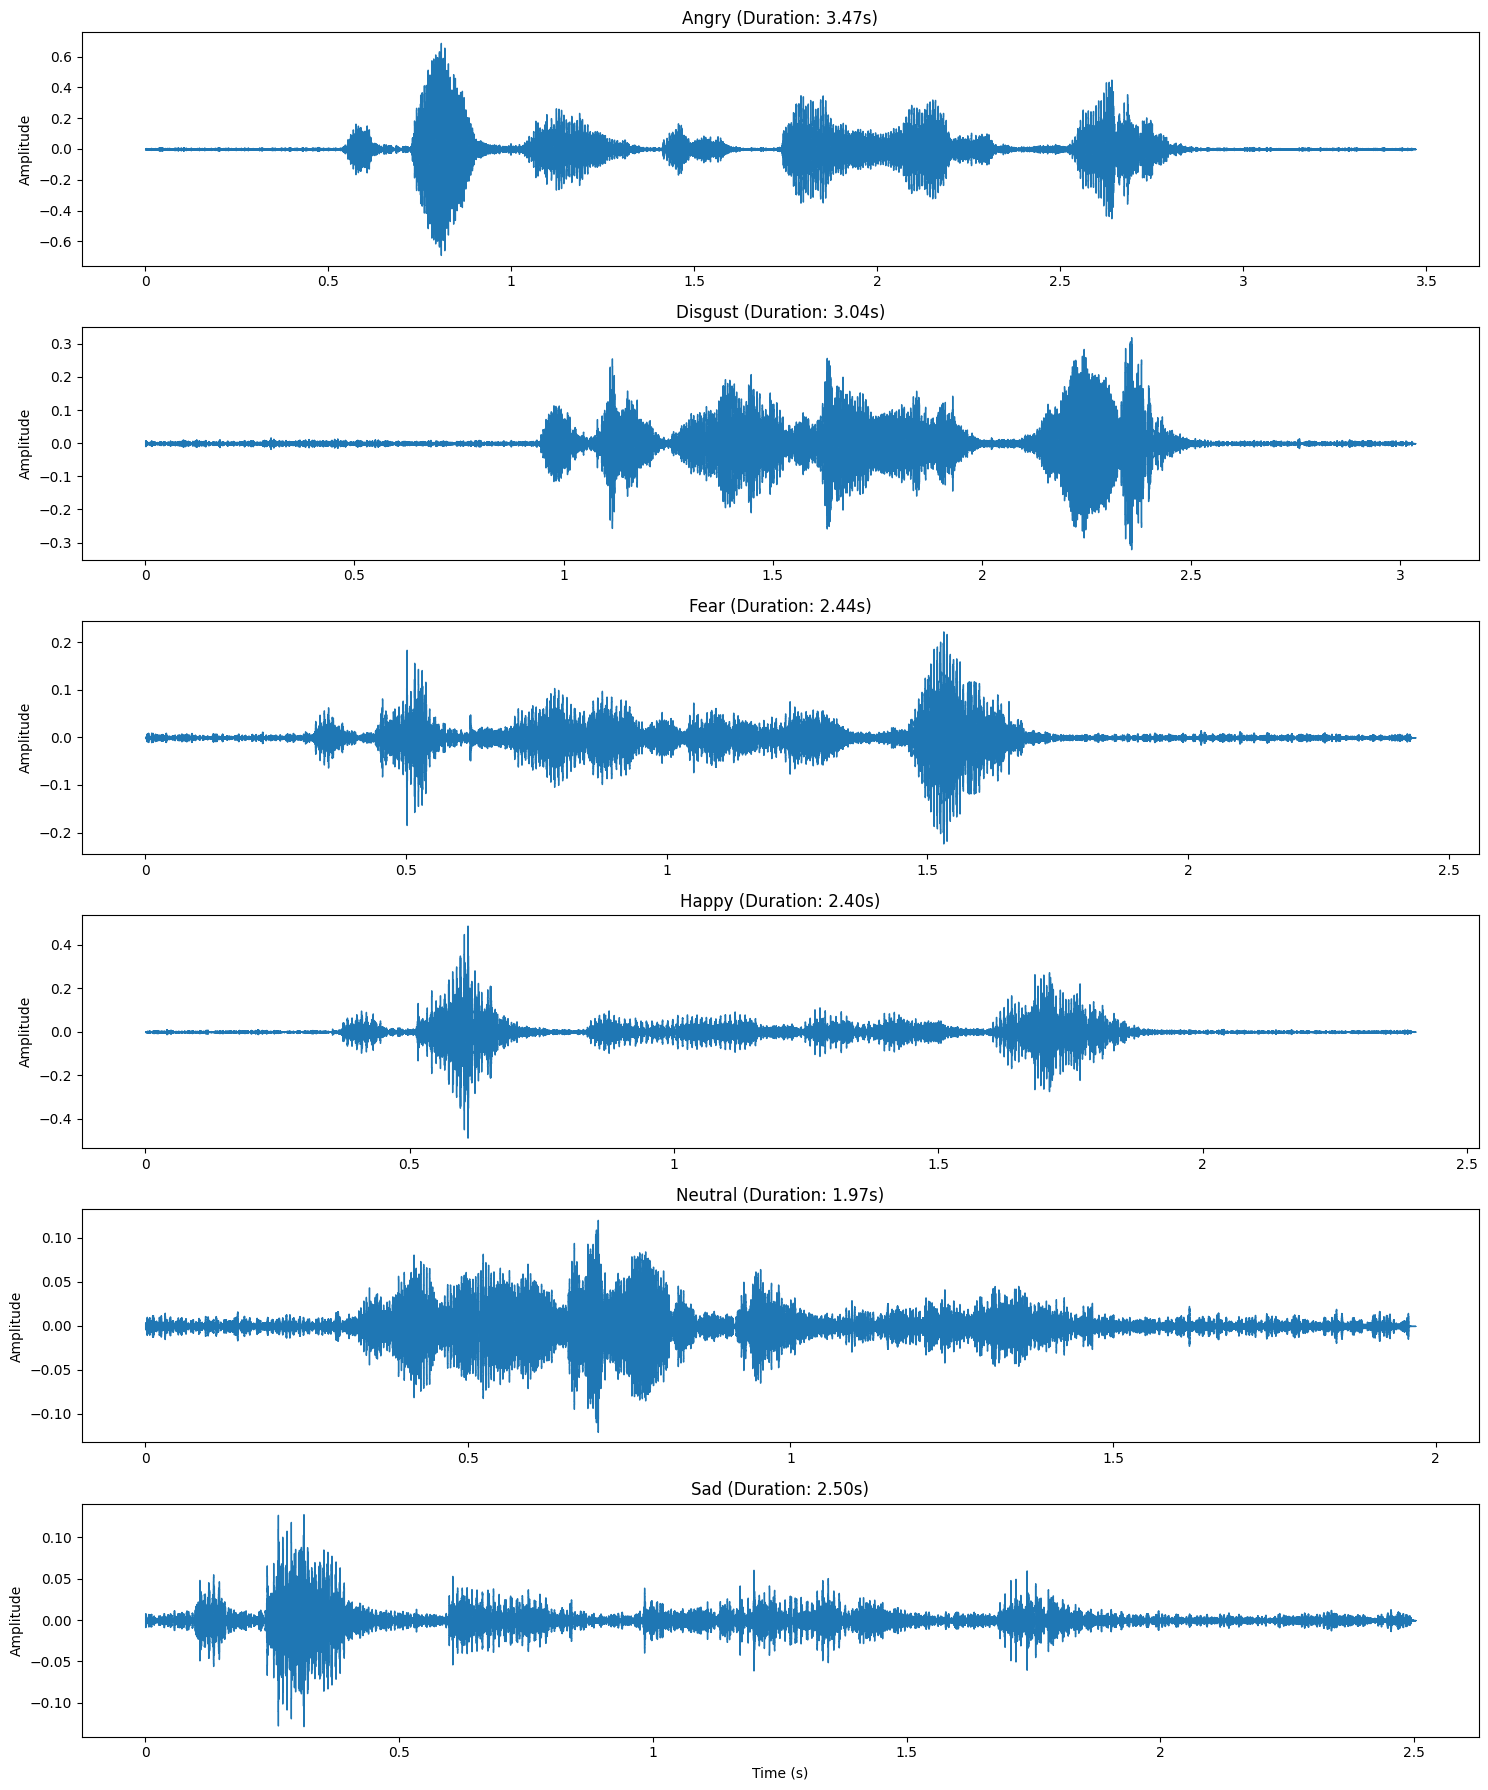

In [21]:
def plot_audio_waveforms(df, num_examples=1):
    
    emotions = df['emotion'].unique()
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=len(emotions), ncols=num_examples, 
                             figsize=(15, 3*len(emotions)))
    if num_examples == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot one example per emotion (more if num_examples > 1)
    for row_idx, emotion in enumerate(emotions):
        # Get random samples for this emotion
        emotion_samples = df[df['emotion'] == emotion].sample(num_examples, random_state=42)
        
        for col_idx in range(num_examples):
            ax = axes[row_idx, col_idx]
            file_path = emotion_samples.iloc[col_idx]['file_path']
            
            # Load audio file
            y, sr = librosa.load(file_path, sr=None)
            
            # Plot waveform
            librosa.display.waveshow(y, sr=sr, ax=ax)
            ax.set(title=f'{emotion.capitalize()} (Duration: {len(y)/sr:.2f}s)',
                  xlabel='' if row_idx != len(emotions)-1 else 'Time (s)',
                  ylabel='Amplitude')
    
    plt.tight_layout()
    plt.show()

# Plot one example per emotion
plot_audio_waveforms(df, num_examples=1)

## Statistics

In [22]:
# Calculate and plot statistics per emotion
stats = []
for emotion in df['emotion'].unique():
    sample = df[df['emotion'] == emotion].sample(100, random_state=42)
    durations = []
    max_amps = []
    for file_path in sample['file_path']:
        y, sr = librosa.load(file_path, sr=None)
        durations.append(len(y)/sr)
        max_amps.append(np.max(np.abs(y)))
    
    stats.append({
        'emotion': emotion,
        'avg_duration': np.mean(durations),
        'avg_max_amp': np.mean(max_amps)
    })

stats_df = pd.DataFrame(stats)

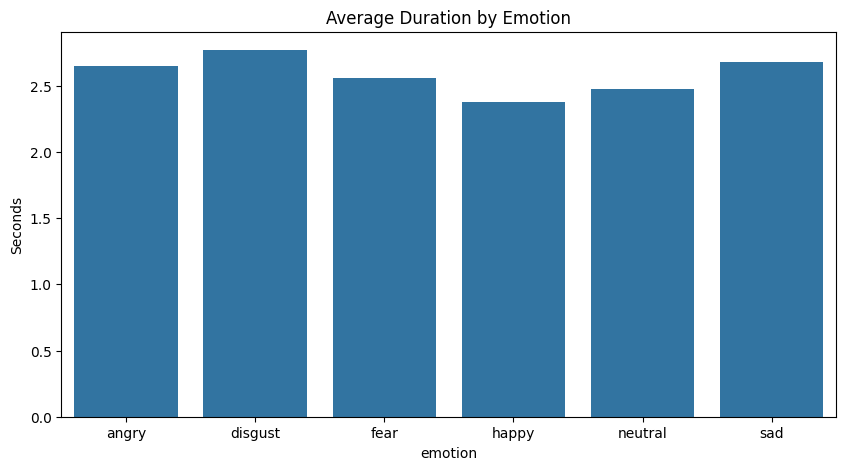

In [23]:
# Plot duration statistics
plt.figure(figsize=(10, 5))
sns.barplot(data=stats_df, x='emotion', y='avg_duration')
plt.title('Average Duration by Emotion')
plt.ylabel('Seconds')
plt.show()

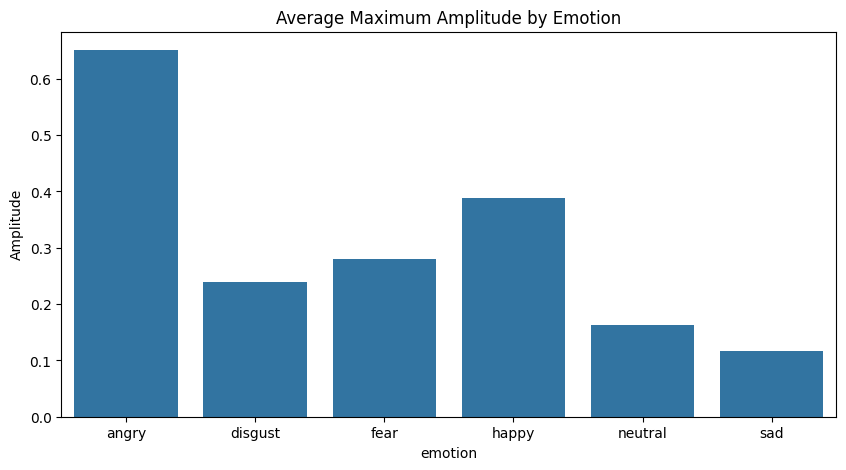

In [24]:
# Plot amplitude statistics
plt.figure(figsize=(10, 5))
sns.barplot(data=stats_df, x='emotion', y='avg_max_amp')
plt.title('Average Maximum Amplitude by Emotion')
plt.ylabel('Amplitude')
plt.show()

## Audio Processing and Feature Extraction
### Time Domain Features (ZCR and Energy)

In [25]:
def extract_time_features(file_path, frame_length=2048, hop_length=512):
    
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)
    
    # Energy (Root Mean Square)
    rmse = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
    
    # Stack features
    features = np.vstack([zcr, rmse])
    
    return features.T  # Transpose to get (time_steps, features)

# Example usage
sample_file = df.iloc[0]['file_path']
time_features = extract_time_features(sample_file)
print("Time features shape:", time_features.shape)

Time features shape: (72, 2)


### Frequency Domain Features (Mel Spectrogram)

Mel spectrogram shape: (128, 72)


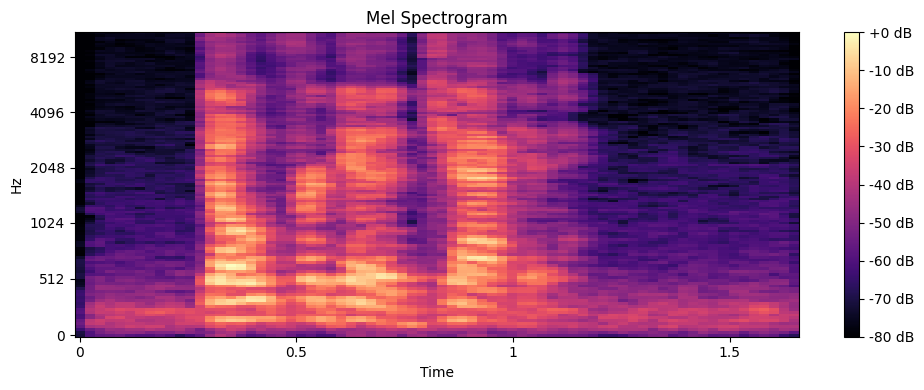

In [26]:
def extract_mel_spectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512):
   
    y, sr = librosa.load(file_path, sr=None)
    
    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                             hop_length=hop_length, n_mels=n_mels)
    
    # Convert to log scale (dB)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel_spec

# Example usage
mel_features = extract_mel_spectrogram(sample_file)
print("Mel spectrogram shape:", mel_features.shape)

# Visualize a sample
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_features, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

## Data Preparation and Splitting

In [27]:
# Prepare features and labels
max_time_steps = 100  # Fixed number of time steps for time features
n_mels = 128
time_feature_dim = 2  # ZCR and Energy

# Initialize arrays
X_time = np.zeros((len(df), max_time_steps, time_feature_dim))
X_mel = np.zeros((len(df), n_mels, max_time_steps, 1))
y = pd.get_dummies(df['emotion']).values

# Extract features for all files
for i, file_path in enumerate(df['file_path']):
    # Time features
    time_feat = extract_time_features(file_path)
    # Pad or truncate to fixed length
    if time_feat.shape[0] >= max_time_steps:
        X_time[i] = time_feat[:max_time_steps]
    else:
        X_time[i, :time_feat.shape[0]] = time_feat
    
    # Mel features
    mel_feat = extract_mel_spectrogram(file_path)
    # Pad or truncate to fixed length
    if mel_feat.shape[1] >= max_time_steps:
        mel_feat = mel_feat[:, :max_time_steps]
    else:
        pad_width = ((0, 0), (0, max_time_steps - mel_feat.shape[1]))
        mel_feat = np.pad(mel_feat, pad_width, mode='constant')
    
    X_mel[i, :, :, 0] = mel_feat

In [28]:
# First split into train+val and test sets (70%/30%)
X_time_train_val, X_time_test, y_train_val, y_test = train_test_split(
    X_time, y, test_size=0.3, stratify=y, random_state=42)

X_mel_train_val, X_mel_test, _, _ = train_test_split(
    X_mel, y, test_size=0.3, stratify=y, random_state=42)

# Then split train+val into train and validation (95%/5% of the original training size)
X_time_train, X_time_val, y_train, y_val = train_test_split(
    X_time_train_val, y_train_val, test_size=0.05, stratify=y_train_val, random_state=42)

X_mel_train, X_mel_val, _, _ = train_test_split(
    X_mel_train_val, y_train_val, test_size=0.05, stratify=y_train_val, random_state=42)

print("Time features shapes:")
print("Train:", X_time_train.shape, "Validation:", X_time_val.shape, "Test:", X_time_test.shape)
print("Mel features shapes:")
print("Train:", X_mel_train.shape, "Validation:", X_mel_val.shape, "Test:", X_mel_test.shape)

Time features shapes:
Train: (4948, 100, 2) Validation: (261, 100, 2) Test: (2233, 100, 2)
Mel features shapes:
Train: (4948, 128, 100, 1) Validation: (261, 128, 100, 1) Test: (2233, 128, 100, 1)


## Model Building
### 1D CNN for Time Domain Features

In [29]:
def build_1d_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(64, 5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Conv1D(256, 5, activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [ ]:
# Build and train 1D CNN
time_cnn = build_1d_cnn((max_time_steps, time_feature_dim), y.shape[1])
time_cnn.summary()

history_time = time_cnn.fit(X_time_train, y_train,
                           validation_data=(X_time_val, y_val),
                           epochs=50, batch_size=32,
                           callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

### 2D CNN for Mel Spectrogram Features

In [ ]:
def build_2d_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [ ]:
# Build and train 2D CNN
mel_cnn = build_2d_cnn((n_mels, max_time_steps, 1), y.shape[1])
mel_cnn.summary()

history_mel = mel_cnn.fit(X_mel_train, y_train,
                         validation_data=(X_mel_val, y_val),
                         epochs=50, batch_size=32,
                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 98, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 98, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,854 (433.02 KB)

 Trainable params: 110,406 (431.27 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - accuracy: 0.3350 - loss: 1.5841 - val_accuracy: 0.2299 - val_loss: 2.1715
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 257ms/step - accuracy: 0.4019 - loss: 1.4506 - val_accuracy: 0.3448 - val_loss: 1.8250
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.4440 - loss: 1.3828 - val_accuracy: 0.3678 - val_loss: 1.5301
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 228ms/step - accuracy: 0.4593 - loss: 1.3525 - val_accuracy: 0.2414 - val_loss: 2.3439
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms/step - accuracy: 0.4768 - loss: 1.3099 - val_accuracy: 0.3027 - val_loss: 3.5017
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - accuracy: 0.5021 - loss: 1.2688 - val_accuracy: 0.4138 - val_loss: 1.3950
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.5255 - loss: 1.2268 - val_accuracy: 0.3180 - val_loss: 2.3007
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 365ms/step - accuracy: 0.5295 - loss: 1

## Model Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, feature_type):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    print(f"\n{feature_type} Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion matrix
    class_names = df['emotion'].unique()
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {feature_type} Features')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return accuracy, f1

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Time Domain Model Evaluation:
Accuracy: 0.4953
F1 Score: 0.4832


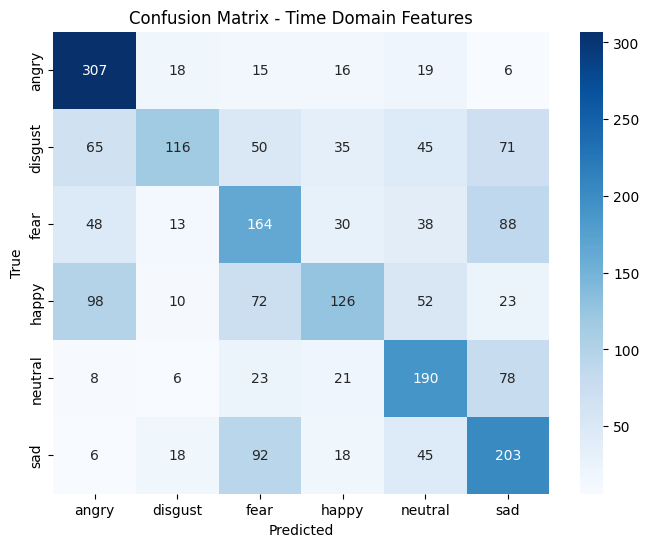

70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step

Mel Spectrogram Model Evaluation:
Accuracy: 0.2575
F1 Score: 0.1483


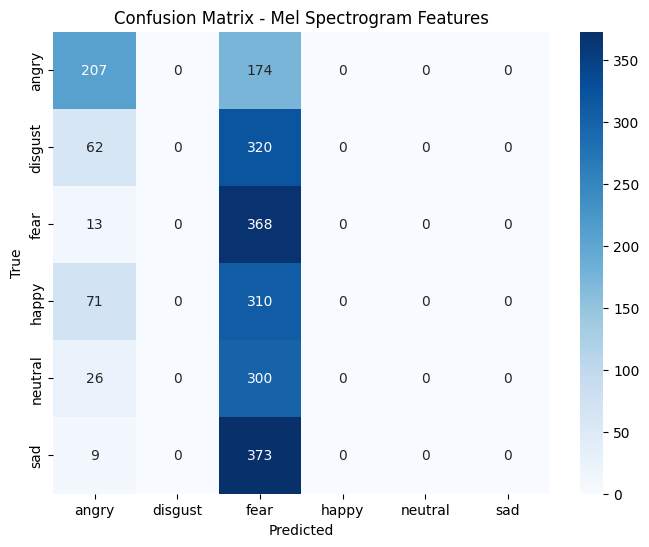


Model Comparison:
Time Domain CNN - Accuracy: 0.4953, F1: 0.4832
Mel Spectrogram CNN - Accuracy: 0.2575, F1: 0.1483


In [ ]:
# Evaluate both models
time_accuracy, time_f1 = evaluate_model(time_cnn, X_time_test, y_test, "Time Domain")
mel_accuracy, mel_f1 = evaluate_model(mel_cnn, X_mel_test, y_test, "Mel Spectrogram")

# Compare models
print("\nModel Comparison:")
print(f"Time Domain CNN - Accuracy: {time_accuracy:.4f}, F1: {time_f1:.4f}")
print(f"Mel Spectrogram CNN - Accuracy: {mel_accuracy:.4f}, F1: {mel_f1:.4f}")